Loading data for Transfer Learning...
Found 367 files belonging to 2 classes.
Using 294 files for training.
Found 367 files belonging to 2 classes.
Using 73 files for validation.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 128, 128, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 128, 128, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
            

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


SUCCESS: Transfer Learning Model saved.


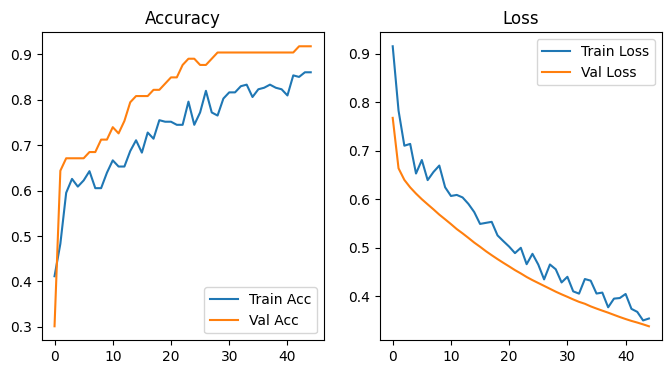

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
dataset_path = r"C:\Users\Dell\OneDrive\Desktop\BOATdl\mixeddatatset" 
img_size = (128, 128)
batch_size = 16

# 1. Load Data (RGB Mode)
# CRITICAL: We load as 'rgb' even though it's sonar.
# This simply copies the grayscale layer 3 times so MobileNet accepts it.
print("Loading data for Transfer Learning...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # 20% for testing
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb' # <--- Changed to RGB for Transfer Learning
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb'
)

# Optimize
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 2. Build Model with Pre-trained Base
# Download MobileNetV2 (without the top classification layer)
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False, 
    weights='imagenet'
)

# Freeze the base! We don't want to retrain these millions of parameters yet.
base_model.trainable = False

# Create our new model on top
inputs = tf.keras.Input(shape=(128, 128, 3))

# Preprocessing included in the model (MobileNet expects specific scaling)
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

# Pass through base model
x = base_model(x, training=False)

# Localization / Classification Head
# We use GlobalAveragePooling to keep spatial awareness for heatmaps later
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Helps prevent overfitting
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compile
# We use a smaller learning rate because we are fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# 3. Train
print("Starting Transfer Learning...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45  # Pre-trained models learn VERY fast. 10 is usually enough.
)

# 4. Save
model.save("topviwandsonar_transfer_model.h5")
print("SUCCESS: Transfer Learning Model saved.")

# 5. Plot Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

Loading model...


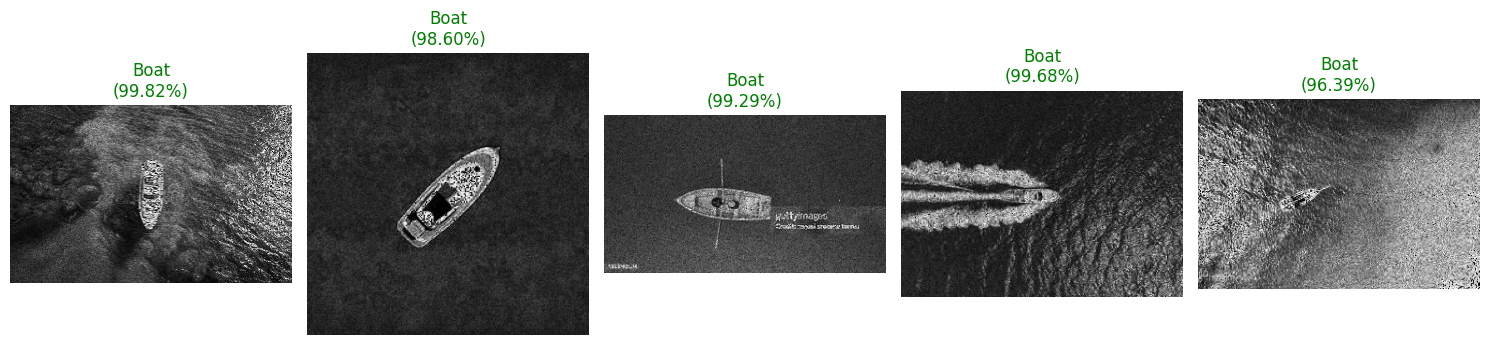

In [4]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
model_path = r"C:\Users\Dell\OneDrive\Desktop\BOATdl\topviwandsonar_transfer_model.h5"
test_folder = r"C:\Users\Dell\OneDrive\Desktop\BOATdl\mixeddatatset\boat"  # We test on known boats first

# Load Model
print("Loading model...")
model = tf.keras.models.load_model(model_path)

# Pick 5 random images
files = [f for f in os.listdir(test_folder) if f.endswith('.jpeg')]
random_files = np.random.choice(files, 5, replace=False)

plt.figure(figsize=(15, 5))

for i, file_name in enumerate(random_files):
    img_path = os.path.join(test_folder, file_name)
    
    # Preprocess
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Ensure RGB
    img_resized = cv2.resize(img, (128, 128))
    img_array = np.expand_dims(img_resized, axis=0) # Shape: (1, 128, 128, 3)
    
    # Predict
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Interpret
    label = "Boat" if prediction > 0.5 else "Background"
    color = "green" if label == "Boat" else "red"
    
    # Plot
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}\n({prediction:.2%})", color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

Loading model...


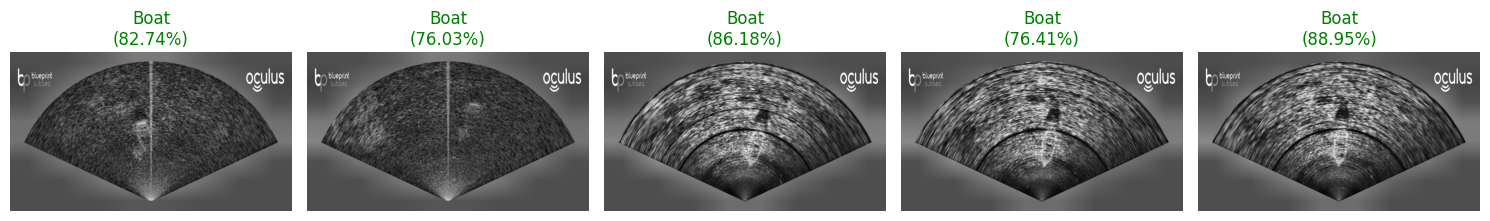

In [5]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
model_path = r"C:\Users\Dell\OneDrive\Desktop\BOATdl\topviwandsonar_transfer_model.h5"
test_folder = r"C:\Users\Dell\OneDrive\Desktop\BOATdl\mixeddatatset\boat"  # We test on known boats first

# Load Model
print("Loading model...")
model = tf.keras.models.load_model(model_path)

# Pick 5 random images
files = [f for f in os.listdir(test_folder) if f.endswith('.png')]
random_files = np.random.choice(files, 5, replace=False)

plt.figure(figsize=(15, 5))

for i, file_name in enumerate(random_files):
    img_path = os.path.join(test_folder, file_name)
    
    # Preprocess
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Ensure RGB
    img_resized = cv2.resize(img, (128, 128))
    img_array = np.expand_dims(img_resized, axis=0) # Shape: (1, 128, 128, 3)
    
    # Predict
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Interpret
    label = "Boat" if prediction > 0.5 else "Background"
    color = "green" if label == "Boat" else "red"
    
    # Plot
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}\n({prediction:.2%})", color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

Loading model...


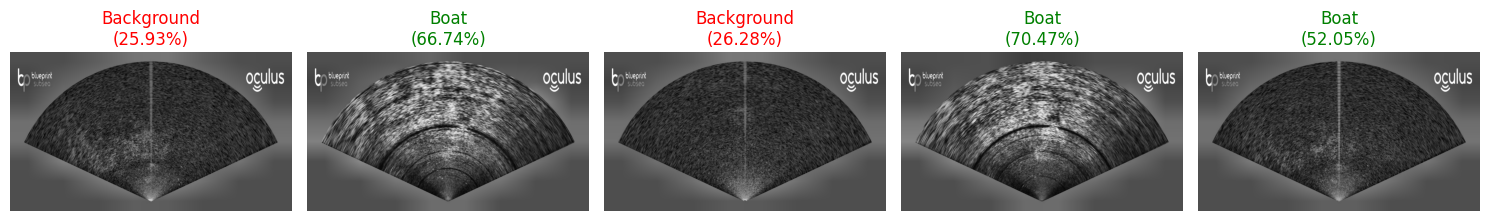

In [6]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
model_path = r"C:\Users\Dell\OneDrive\Desktop\BOATdl\topviwandsonar_transfer_model.h5"
test_folder = r"C:\Users\Dell\OneDrive\Desktop\BOATdl\mixeddatatset\background"  # We test on known boats first

# Load Model
print("Loading model...")
model = tf.keras.models.load_model(model_path)

# Pick 5 random images
files = [f for f in os.listdir(test_folder) if f.endswith('.png')]
random_files = np.random.choice(files, 5, replace=False)

plt.figure(figsize=(15, 5))

for i, file_name in enumerate(random_files):
    img_path = os.path.join(test_folder, file_name)
    
    # Preprocess
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Ensure RGB
    img_resized = cv2.resize(img, (128, 128))
    img_array = np.expand_dims(img_resized, axis=0) # Shape: (1, 128, 128, 3)
    
    # Predict
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Interpret
    label = "Boat" if prediction > 0.5 else "Background"
    color = "green" if label == "Boat" else "red"
    
    # Plot
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}\n({prediction:.2%})", color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

Loading Validation Data...
Found 367 files belonging to 2 classes.
Using 73 files for validation.
Generating predictions...

--- Model Loss: 0.3379 ---
Precision: 0.9074
Recall:    0.9800
F1 Score:  0.9423

--- Detailed Classification Report ---
              precision    recall  f1-score   support

  Background       0.95      0.78      0.86        23
        Boat       0.91      0.98      0.94        50

    accuracy                           0.92        73
   macro avg       0.93      0.88      0.90        73
weighted avg       0.92      0.92      0.92        73



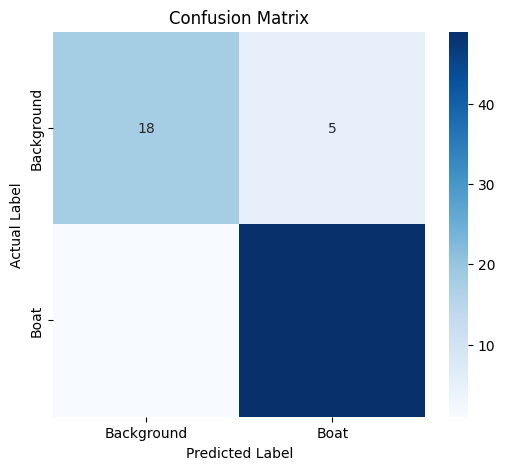

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, log_loss, f1_score, precision_score, recall_score
import os

# --- CONFIGURATION ---
model_path = "topviwandsonar_transfer_model.h5"
dataset_path = "mixeddatatset"
img_size = (128, 128)
batch_size = 16

# 1. Load Validation Data (SHUFFLE = TRUE)
# We turn shuffle BACK ON so we get a mix of Boat and Background
print("Loading Validation Data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True # <--- Changed to True to fix the "One Label" error
)

# 2. Extract Labels and Predictions safely
y_true = []
y_pred_probs = []

print("Generating predictions...")
model = tf.keras.models.load_model(model_path)

# We loop through the batch. 
# Because we grab 'images' and 'labels' together, they will always match.
for images, labels in val_ds:
    # 1. Store the true labels from this batch
    y_true.extend(labels.numpy())
    
    # 2. Make predictions on THIS specific batch of images
    preds = model.predict(images, verbose=0)
    y_pred_probs.extend(preds.flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# --- 3. CALCULATE METRICS ---

# Check if we successfully grabbed both classes
unique_labels = np.unique(y_true)
if len(unique_labels) < 2:
    print(f"WARNING: Still only found labels: {unique_labels}. Try increasing validation_split size.")
else:
    # A. Loss (Log Loss) - We explicitly tell it labels are [0, 1] to prevent crashes
    loss = log_loss(y_true, y_pred_probs, labels=[0, 1])
    print(f"\n--- Model Loss: {loss:.4f} ---")

    # B. The 'Big 3' Metrics
    precision = precision_score(y_true, y_pred_classes, zero_division=0)
    recall = recall_score(y_true, y_pred_classes, zero_division=0)
    f1 = f1_score(y_true, y_pred_classes, zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # C. Full Report
    print("\n--- Detailed Classification Report ---")
    print(classification_report(y_true, y_pred_classes, target_names=['Background', 'Boat'], zero_division=0))

    # --- 4. VISUALIZE CONFUSION MATRIX ---
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Background', 'Boat'], 
                yticklabels=['Background', 'Boat'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()